In [12]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression

from fairlearn import datasets
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import RocAuc

# Plot ROC Curve by Sensitive Feature

To understand the performance of a classification model, it is common to plot the Receiver Operator Curve (ROC). The ROC Curve helps to visualize the trade off between between sensitivity (or True Positive Rate) and specificity (1 – False Positive Rate) for all possible thresholds of a classification model.

For most classifiers, the default threshold for the decision function is .50, or 50%. In other words, a result with a probability greater than .50 will be classified as the positive class. A result with a probability less than .50, will be classified as the negative class. Misclassification can result in false negatives and false positives.

The ROC curve  plots the True Postive Rate against the False Positive Rate for each possible threshold.  The (0,1) point indicates perfect classification, representing 100% sensitivity (no false negatives) and 100% specificity (no false positives). A random guess would give a point along a diagonal line (the so-called line of no-discrimination).  

The Area under the Curve, or AUC score gives a sense of the overall performance of the model. The greater the AUC score the better the models ability to correctly classify the target. 

In comparing the sensitive features by subgroup, a model that resulted in the same ROC Curve for all subgroups could be considered a perfectly "fair" model. (In the real world, of course, it is not that simple and other factors come into play.) It was able to determine the class for each subgroup at each threshold equally well. If there is variation between the ROC curves, it is an indication that the model performs differently for different subgroups. 

One way to adjust the model, is to adjust the threshold used by the decision function. In this way, we can make the model more or less sensitive and reduce the variance between the AUC scores across subgroups.

The RocAuc module in Fairlearn allows you to easily plot ROC Curves and compute AUC scores by sensitive feature. 

**Note: To use this module, you will need to install Matplotlib if it is not already installed.**

# Load data

For this example we use the UCI adult dataset where the objective is to predict whether a person makes more (label 1) or less (0) than $50,000 a year.

In [2]:
# Load data
data = datasets.fetch_adult(as_frame=True)['data']
target = datasets.fetch_adult(as_frame=True)['target']

In [3]:
display(data.shape)
print("Number of records:", len(target))
display(data.head(3))
print("Target classifications:", set(target))
display(target[0:3])

(48842, 14)

Number of records: 48842


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States


Target classifications: {'<=50K', '>50K'}


0    <=50K
1    <=50K
2     >50K
Name: class, dtype: category
Categories (2, object): ['>50K', '<=50K']

# Model Example

ToDo - Add explanation of model here. 

In [4]:
# Extract into X, y and A
sensitive_features = ['sex', 'race']
data_cols = [x for x in data if x not in sensitive_features]

# Predictors
ohe = OneHotEncoder()
X = ohe.fit_transform(data[data_cols])

le = LabelEncoder()
y = le.fit_transform(target)
A = data[sensitive_features]

# Split into test and train, making sure we also split the sensitive features to plot
X_train, X_test, y_train, y_test, A_train, A_test = \
    train_test_split(X, y, A, test_size=0.33, random_state=123)

In [5]:
# Fit model
clf = LogisticRegression(solver='liblinear', fit_intercept=True)
clf.fit(X_train, y_train)
y_score = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

# Get probabilies for positive prediction
y_score = y_score[:, 1]

# Get probabiliies for random (no skill)
ns_probs = [0 for n in range(len(y_test))]

## Default configuration

Here is a the most basic example.

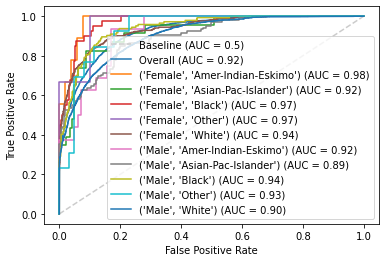

In [6]:
# Plot ROC curves by group
rc = RocAuc(y_test, y_score, A_test)
roc_plot = rc.plot_by_group()

However this might be difficult to read. Particularly if the data you are working with has a number of sensitive features to compare. You can customize the plot for readability by either passing fewer sensitive features to be plotted or by customizing the plot itself. 

# Configured with Parameters

For ease of interpretation, you can configure the size of the plot, or plot only selected groupings of sensitive features. It is common to plot the  

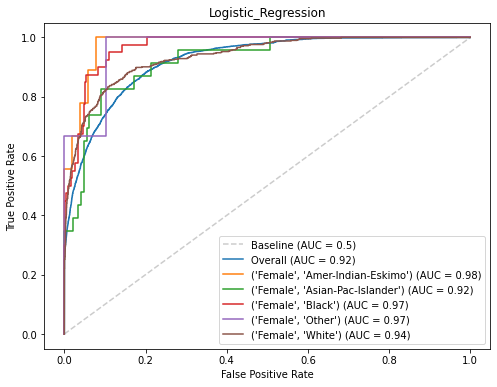

In [8]:
# Establish plot figure
plt.figure(figsize=(8, 6))
ax = plt.gca()

rc = RocAuc(y_test, y_score, A_test)
by_group = rc.by_group()
female_only = [x for x in by_group.index if 'Female' in x]
rc.plot_by_group( 
    sensitive_index=female_only, 
    title = "Logistic_Regression",
    ax=ax,
    include_overall=True,
    include_baseline=True,
)
plt.show()

For ease, it is also possible to generate the Area Under the Curve (AUC) score by sensitive feature. 

In [9]:
auc_scores = rc.auc_by_group()
auc_scores

{('Female', 'Amer-Indian-Eskimo'): 0.9782135076252724,
 ('Female', 'Asian-Pac-Islander'): 0.9237641453245979,
 ('Female', 'Black'): 0.9689024390243902,
 ('Female', 'Other'): 0.9659863945578231,
 ('Female', 'White'): 0.9360880134378032,
 ('Male', 'Amer-Indian-Eskimo'): 0.9179216867469879,
 ('Male', 'Asian-Pac-Islander'): 0.8942403628117914,
 ('Male', 'Black'): 0.9402619949494949,
 ('Male', 'Other'): 0.9319041614123581,
 ('Male', 'White'): 0.9008740280446366}

In [10]:
auc_scores_female = rc.auc_by_group(female_only)
auc_scores_female

{('Female', 'Amer-Indian-Eskimo'): 0.9782135076252724,
 ('Female', 'Asian-Pac-Islander'): 0.9237641453245979,
 ('Female', 'Black'): 0.9689024390243902,
 ('Female', 'Other'): 0.9659863945578231,
 ('Female', 'White'): 0.9360880134378032,
 ('Male', 'Amer-Indian-Eskimo'): 0.9179216867469879,
 ('Male', 'Asian-Pac-Islander'): 0.8942403628117914,
 ('Male', 'Black'): 0.9402619949494949,
 ('Male', 'Other'): 0.9319041614123581,
 ('Male', 'White'): 0.9008740280446366}

## Custom Plot Style

To customize the plot, first create a plot using the Matplotlib library. 

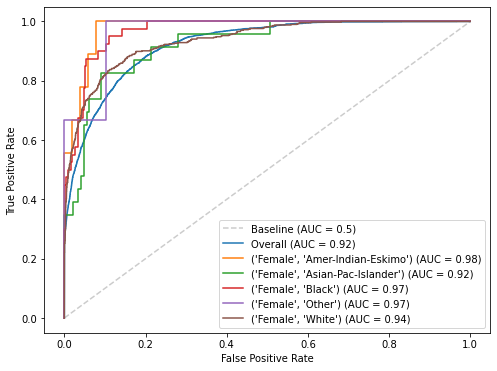

In [11]:
# Establish plot figure
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Plot ROC curves by group
rc = RocAuc(y_test, y_score, A_test)
rc.plot_by_group(sensitive_index=female_only, ax=ax)
plt.style.use('ggplot')
plt.show()